# Tutorial 2: ABL case

This case will demonstrate how to use the `amrwind-frontend` python interface to setup an ABL case.  The case is a slightly unstable ABL case patterned after the IEA29 REF1 conditions measured off the coast of Denmark.

In [1]:
# Load the modules
amrwindfedir = '../../'
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

We first initialize the class using the `MyApp.init_nogui()` constructor.

In [2]:
# Start the case
case = amrwind.MyApp.init_nogui()

We'll set the basic time marching parameters next.  We want to run for 20,000 seconds, or 40,000 iterations with dt=0.5

In [3]:
case.setAMRWindInput('time.stop_time', 20000.0)
case.setAMRWindInput('time.max_step',  40000)

case.setAMRWindInput('time.fixed_dt',  0.5)
case.setAMRWindInput('time.checkpoint_interval',  2000)

Next we set the simulation type: This is an ABL case, 1-eqn KSGS model.  The WENO scheme will be used as well.

In [4]:
case.setAMRWindInput('incflo.physics',      ['ABL'])
case.setAMRWindInput('incflo.verbose',      3)
case.setAMRWindInput('io.check_file',       'chk')

case.setAMRWindInput('incflo.use_godunov',  True)
case.setAMRWindInput('incflo.godunov_type', 'weno')

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])

case.setAMRWindInput('transport.viscosity', 1.8375e-05)

The statements above used the `setAMRWindInput()` calls.  The `loadAMRWindInput()` call can be used as well to set specific variables, as demonstrated by the tolerance parameters below:

In [5]:
# I'm lazy, just do this in a string
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

We'll set the domain and boundary conditions next.  The physical domain will be 1.5km x 1.5km x 1.9km, with a 128 x 128 x 160 grid, for a mesh size of 12m cubed.

In [6]:
case.setAMRWindInput('geometry.prob_lo', [ 0.0, 0.0, 0.0 ])
case.setAMRWindInput('geometry.prob_hi', [1536.0, 1536.0, 1920.0])
case.setAMRWindInput('amr.n_cell',       [128, 128, 160])

The boundary conditions set set to be periodic in the $x$ and $y$ directions.  In the $z$ direction, a wall model is used at the bottom, and a slip wall at the top with a fixed temperature gradient.

In [7]:
case.setAMRWindInput('is_periodicx', True)
case.setAMRWindInput('is_periodicy', True)
case.setAMRWindInput('is_periodicz', False)

case.setAMRWindInput('zlo.type',              'wall_model')          
case.setAMRWindInput('zlo.temperature_type',  'wall_model')          
case.setAMRWindInput('zlo.tke_type',          'zero_gradient')       
case.setAMRWindInput('zhi.type',              'slip_wall')           
case.setAMRWindInput('zhi.temperature_type',  'fixed_gradient')      
case.setAMRWindInput('zhi.temperature',       0.000974025974) 

The exact ABL parameters are set below.  Many of these are standard settings, but the important ones are:

- `incflo.velocity`: The desired hubheight velocity
- `ABLForcing.abl_forcing_height`: The turbine hub-height
- `ABL.surface_roughness_z0`:  The surface roughness 
- `ABL.reference_temperature`: The reference temperature for teh ABL
- `ABL.surface_temp_flux`: The amount of temperature flux through the lower surface

In [8]:
case.setAMRWindInput('ICNS.source_terms',     ['ABLForcing','BoussinesqBuoyancy', 'CoriolisForcing'])

case.setAMRWindInput('ABL.stats_output_frequency',   1)                   
case.setAMRWindInput('ABL.stats_output_format',      'netcdf')

case.setAMRWindInput('incflo.velocity', [4.70059422901, 3.93463008353, 0.0])
case.setAMRWindInput('ABLForcing.abl_forcing_height',   57.19)
case.setAMRWindInput('ABL.kappa',                       0.4) 

case.setAMRWindInput('ABL.normal_direction',      2)
case.setAMRWindInput('ABL.surface_roughness_z0',  0.0001)
case.setAMRWindInput('ABL.reference_temperature', 288.15)
case.setAMRWindInput('ABL.surface_temp_rate',     0.0)
case.setAMRWindInput('ABL.surface_temp_flux',     0.0122096146646)

case.setAMRWindInput('ABL.mo_beta_m',             16.0)
case.setAMRWindInput('ABL.mo_gamma_m',            5.0)
case.setAMRWindInput('ABL.mo_gamma_h',            5.0)
case.setAMRWindInput('ABL.random_gauss_mean',     0.0)
case.setAMRWindInput('ABL.random_gauss_var',      1.0)

The latitude of the case is set below (important for Coriolis effects).  Also the initial temperature profile is given as a series of strings for the heights and temperature values

In [9]:
case.setAMRWindInput('CoriolisForcing.latitude',  55.49)
case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 288.15) 

case.setAMRWindInput('ABL.temperature_heights', '1050.0 1150.0 1920.0')
case.setAMRWindInput('ABL.temperature_values',  '288.15 296.15 296.9')

In [10]:
# This is a case where we don't want to use the defaults in amrwind-frontend
case.setAMRWindInput('ABL.perturb_ref_height', None)
case.setAMRWindInput('ABL.Uperiods', None)
case.setAMRWindInput('ABL.Vperiods', None)
case.setAMRWindInput('ABL.deltaU',   None)
case.setAMRWindInput('ABL.deltaV',   None)
case.setAMRWindInput('ABL.theta_amplitude',   None)
case.setAMRWindInput('ABL.cutoff_height',   None)

Some of the I/O and output settings are given below.  We want to write full-field plot files every 2000 iterations, and include sampling planes written every 100 iterations

In [11]:
case.setAMRWindInput('time.plot_interval', 2000)

case.setAMRWindInput('incflo.post_processing', ['sampling'])            
case.setAMRWindInput('sampling.output_frequency', 100)                 
case.setAMRWindInput('sampling.fields',           ['velocity', 'temperature'])

The sampling planes are specified below.  We want a hub-height plane and also some planes around the periodic sides.

In [12]:
sampleplane = case.get_default_samplingdict()
# Modify the geometry
sampleplane['sampling_name']         = 'p_hub'
sampleplane['sampling_type']         = 'PlaneSampler'
sampleplane['sampling_p_num_points'] = [129, 129]
sampleplane['sampling_p_origin']     = [0, 0, 0]
sampleplane['sampling_p_axis1']      = [1536, 0, 0]
sampleplane['sampling_p_axis2']      = [0, 1536, 0]
sampleplane['sampling_p_normal']     = [0, 0, 1]
sampleplane['sampling_p_offsets']    = '17        28.5      41        57        77        90'
case.add_sampling(sampleplane)

sampleplane = case.get_default_samplingdict()
sampleplane['sampling_name']         = 'xbc'
sampleplane['sampling_type']         = 'PlaneSampler'
sampleplane['sampling_p_num_points'] = [257, 161]
sampleplane['sampling_p_origin']     = [0, 0, 0]
sampleplane['sampling_p_axis1']      = [0, 1536, 0]
sampleplane['sampling_p_axis2']      = [0, 0, 1920]
sampleplane['sampling_p_normal']     = [1, 0, 0]
sampleplane['sampling_p_offsets']    = '0.0 1536'
case.add_sampling(sampleplane)

sampleplane = case.get_default_samplingdict()
sampleplane['sampling_name']         = 'ybc'
sampleplane['sampling_type']         = 'PlaneSampler'
sampleplane['sampling_p_num_points'] = [257, 161]
sampleplane['sampling_p_origin']     = [0, 0, 0]
sampleplane['sampling_p_axis1']      = [1536, 0, 0]
sampleplane['sampling_p_axis2']      = [0, 0, 1920]
sampleplane['sampling_p_normal']     = [0, 1, 0]
sampleplane['sampling_p_offsets']    = '0.0 1536'
case.add_sampling(sampleplane)

### Plot the domain
The domain and wind direction are plotted using the `plotDomain()` function.  You can get a quick idea of the sampling planes and wind direction relative to everything else.

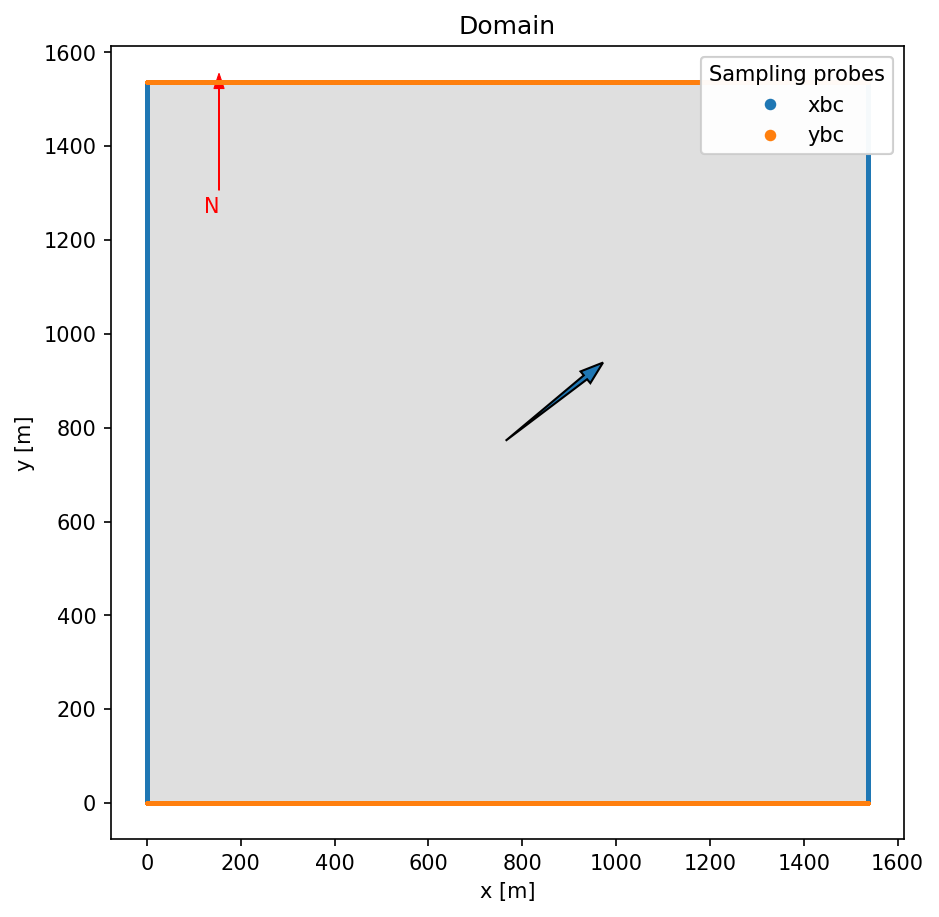

In [13]:
fig, ax = plt.subplots(figsize=(7,7), facecolor='w', dpi=150)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['xbc', 'ybc'] #['p_hub']
case.plotDomain(ax=ax)

### Write the input file
Finally, we write out the input file:

In [14]:
# Write the input file
case.writeAMRWindInput('tutorial2.inp');